# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Epilepsy a ser clasificado por una codificación simbólica con ``Tendencia`` y ``Aceleración`` aplicada a SMTS

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/SMTS/Epilepsy/"
PKL_NAME = "epilepsy_SMTS_codifsimb_trend_acc.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here


# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues las series son muy cortas y, aplicar un enventanado que divida las series en subseries, daría como resultado series mucho más cortas de las que sería más difícil extraer patrones en el caso de clases como ``epilepsy``, por ejemplo.

In [8]:
# Nothing to see here

## <font color=#cd0000> Codificación </font>

In [9]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


In [10]:
columns = train.get_derived_data_columns()['attrs']
trend_columns = list(filter(lambda z: 'Diff' in z, columns))

train.apply_codifications([temporal_trend_fn], headers=trend_columns)
test.apply_codifications([temporal_trend_fn], headers=trend_columns)


# <font color=#cd0000> Preparación de los datos </font>

In [11]:
X_train = train.derived_data.drop(['TimeStamp', 'class'], axis=1)
X_test = test.derived_data.drop(['TimeStamp', 'class'], axis=1)

y_train = train.derived_data['class'].to_numpy()
y_test = test.derived_data['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [12]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'epilepsy': class_weights[0], 'running': class_weights[1],
                 'sawing': class_weights[2], 'walking': class_weights[3]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de árboles inicial recomendado
- Número de símbolos inicial recomendado
- Número de árboles del segundo RandomForest recomendado

## <font color=#cd0000> Entrenamiento </font>

In [25]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=100,
    n_symbols=100,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id')\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[32  0  1  1]
 [ 1 34  2  0]
 [ 0  0 30  0]
 [ 0  0  0 37]]
              precision    recall  f1-score   support

    epilepsy       0.97      0.94      0.96        34
     running       1.00      0.92      0.96        37
      sawing       0.91      1.00      0.95        30
     walking       0.97      1.00      0.99        37

    accuracy                           0.96       138
   macro avg       0.96      0.97      0.96       138
weighted avg       0.97      0.96      0.96       138



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `j_ins` pequeño (10) y un `n_symbols` pequeño (10) observamos unos resultados mejores todavía que al aplicar únicamente una Codificación simbólica con ``Tendencia``:
    ```
    Confusion matrix:
    [[30  1  1  2]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.88      0.92        34
         running       0.97      0.97      0.97        37
          sawing       0.97      1.00      0.98        30
         walking       0.95      1.00      0.97        37

        accuracy                           0.96       138
       macro avg       0.96      0.96      0.96       138
    weighted avg       0.96      0.96      0.96       138
    ```
  - Para un `j_ins` pequeño (10) y un `n_symbols` grande (200) observamos una ligera mejora:
    ```
    Confusion matrix:
    [[31  0  1  2]
     [ 1 36  0  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.91      0.94        34
         running       1.00      0.97      0.99        37
          sawing       0.97      1.00      0.98        30
         walking       0.95      1.00      0.97        37

        accuracy                           0.97       138
       macro avg       0.97      0.97      0.97       138
    weighted avg       0.97      0.97      0.97       138
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` pequeño (10) observamos unos resultados similares:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 0 35  2  0]
     [ 0  0 30  0]
     [ 1  0  0 36]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.94      0.96        34
         running       1.00      0.95      0.97        37
          sawing       0.91      1.00      0.95        30
         walking       0.97      0.97      0.97        37

        accuracy                           0.96       138
       macro avg       0.96      0.97      0.96       138
    weighted avg       0.97      0.96      0.96       138
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` grande (200) observamos los mejores resultados que hemos obtenido hasta ahora:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 0 37  0  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       1.00      0.94      0.97        34
         running       1.00      1.00      1.00        37
          sawing       0.97      1.00      0.98        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.99       138
       macro avg       0.99      0.99      0.98       138
    weighted avg       0.99      0.99      0.99       138
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` intermedio (100) observamos ...:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 33  3  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                      precision    recall  f1-score   support

        epilepsy       0.97      0.94      0.96        34
         running       1.00      0.89      0.94        37
          sawing       0.88      1.00      0.94        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.96       138
       macro avg       0.96      0.96      0.96       138
    weighted avg       0.96      0.96      0.96       138
    ```
  - Para un `j_ins` intermedio (100) y un `n_symbols` grande (200) observamos ...:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 35  1  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.94      0.96        34
         running       1.00      0.95      0.97        37
          sawing       0.94      1.00      0.97        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.97       138
       macro avg       0.97      0.97      0.97       138
    weighted avg       0.97      0.97      0.97       138
    ```

  - Para un `j_ins` intermedio (100) y un `n_symbols` intermedio (100) observamos ...:
    ```
    Confusion matrix:
    [[32  0  1  1]
     [ 1 34  2  0]
     [ 0  0 30  0]
     [ 0  0  0 37]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.97      0.94      0.96        34
         running       1.00      0.92      0.96        37
          sawing       0.91      1.00      0.95        30
         walking       0.97      1.00      0.99        37

        accuracy                           0.96       138
       macro avg       0.96      0.97      0.96       138
    weighted avg       0.97      0.96      0.96       138
    ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar los resultados son todos muy buenos al aplicar la codificación de la ``Tendencia`` y la ``Aceleración`` junto con la simbólica
- El rango orientativo de valores en el que buscaremos es:
  - `n_estimators`: [100, 200]
  - `max_depth`: [100, 200]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con SMTS maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [27]:
J_INS_RANGE = range(100, 200)
N_SYMBOLS_RANGE = range(100, 200)

In [28]:
import random
import pickle
import utils.constants as cs
from smts_implementation.smts import SMTS
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def smts_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        cv=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    j_ins_list = random.sample(list(J_INS_RANGE), n_samples)
    n_symbols_list = random.sample(list(N_SYMBOLS_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for j_ins in j_ins_list:
        for n_symbols in n_symbols_list:
            clf = SMTS(
                j_ins=j_ins,
                n_symbols=n_symbols,
                class_weight=class_weights,
                random_state=SEED
            )

            reports = windowed_cross_val(
                clf,
                windowed_series,
                relation_with_series,
                estimator_type=cs.ESTIMATOR_SMTS,
                cv=cv,
                drop_columns=['class'],
                seed=SEED
            )
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(j_ins, n_symbols)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (j_ins, n_symbols)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: J_ins={}; N_symbols={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: J_ins={}; N_symbols={}--------------"
                  .format(j_ins, n_symbols))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [29]:
smts_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    cv=5
)


		--------------ACTUAL BEST: J_ins=156; N_symbols=197--------------
Accuracy: 0.9496807151979565 +/- 0.035417075934599807
epilepsy:
	precision: 0.9214285714285715 +/- 0.10202040612204072
	recall: 0.8706349206349205 +/- 0.07998173134821666
	f1-score: 0.8910924369747899 +/- 0.07067141957342936
	support: 6.8 +/- 1.6
running:
	precision: 0.9527777777777778 +/- 0.05800170282728085
	recall: 0.975 +/- 0.049999999999999996
	f1-score: 0.9615686274509805 +/- 0.031509504982903
	support: 7.2 +/- 1.16619037896906
sawing:
	precision: 0.9714285714285713 +/- 0.05714285714285716
	recall: 1.0 +/- 0.0
	f1-score: 0.9846153846153847 +/- 0.030769230769230795
	support: 6.0 +/- 0.6324555320336759
walking:
	precision: 0.9666666666666668 +/- 0.06666666666666667
	recall: 0.9349999999999999 +/- 0.08306623862918074
	f1-score: 0.9462626262626262 +/- 0.04607832372332255
	support: 7.4 +/- 2.0591260281974
macro avg:
	precision: 0.9530753968253969 +/- 0.03280356608812154
	recall: 0.9451587301587301 +/- 0.03642256235668

((156, 134),
 {'accuracy': (0.957088122605364, 0.04087324365300023),
  'epilepsy': {'precision': (0.9214285714285715, 0.10202040612204072),
   'recall': (0.9206349206349206, 0.06582997255024675),
   'f1-score': (0.9196638655462184, 0.07949704193601494),
   'support': (6.8, 1.6)},
  'running': {'precision': (0.9777777777777779, 0.04444444444444447),
   'recall': (0.975, 0.049999999999999996),
   'f1-score': (0.9749019607843138, 0.03083859333543137),
   'support': (7.2, 1.16619037896906)},
  'sawing': {'precision': (0.9714285714285713, 0.05714285714285716),
   'recall': (1.0, 0.0),
   'f1-score': (0.9846153846153847, 0.030769230769230795),
   'support': (6.0, 0.6324555320336759)},
  'walking': {'precision': (0.9666666666666668, 0.06666666666666667),
   'recall': (0.9349999999999999, 0.08306623862918074),
   'f1-score': (0.9462626262626262, 0.04607832372332255),
   'support': (7.4, 2.0591260281974)},
  'macro avg': {'precision': (0.9593253968253969, 0.03779228079621944),
   'recall': (0.9

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- No llevaremos a cabo esta aproximación ya que tenemos datos suficientes como para ejecutar validación cruzada.

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``j_ins`` = 156 y ``n_symbols`` = 134:
    ```
        Accuracy: 0.957088122605364 +/- 0.04087324365300023
        epilepsy:
            precision: 0.9214285714285715 +/- 0.10202040612204072
            recall: 0.9206349206349206 +/- 0.06582997255024675
            f1-score: 0.9196638655462184 +/- 0.07949704193601494
            support: 6.8 +/- 1.6
        running:
            precision: 0.9777777777777779 +/- 0.04444444444444447
            recall: 0.975 +/- 0.049999999999999996
            f1-score: 0.9749019607843138 +/- 0.03083859333543137
            support: 7.2 +/- 1.16619037896906
        sawing:
            precision: 0.9714285714285713 +/- 0.05714285714285716
            recall: 1.0 +/- 0.0
            f1-score: 0.9846153846153847 +/- 0.030769230769230795
            support: 6.0 +/- 0.6324555320336759
        walking:
            precision: 0.9666666666666668 +/- 0.06666666666666667
            recall: 0.9349999999999999 +/- 0.08306623862918074
            f1-score: 0.9462626262626262 +/- 0.04607832372332255
            support: 7.4 +/- 2.0591260281974
        macro avg:
            precision: 0.9593253968253969 +/- 0.03779228079621944
            recall: 0.95765873015873 +/- 0.04195396041684983
            f1-score: 0.9563609593021358 +/- 0.04126433230592285
            support: 27.4 +/- 0.8
        weighted avg:
            precision: 0.9618550953799996 +/- 0.03647998366223763
            recall: 0.957088122605364 +/- 0.04087324365300023
            f1-score: 0.9575084373551807 +/- 0.040316839680829664
            support: 27.4 +/- 0.8
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [30]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


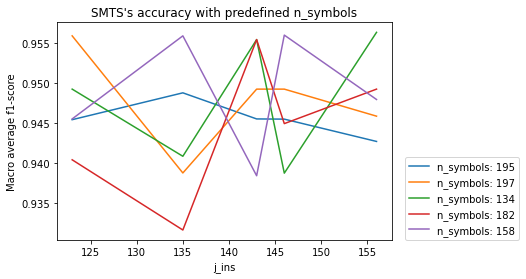

In [31]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


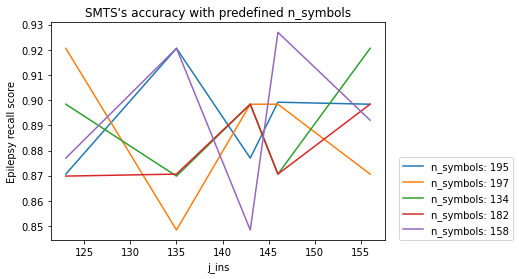

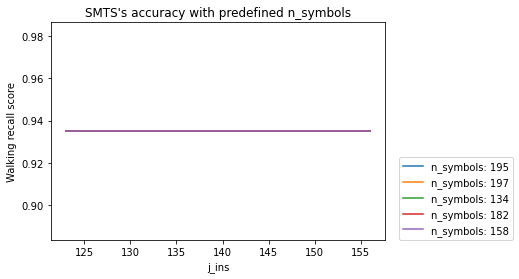

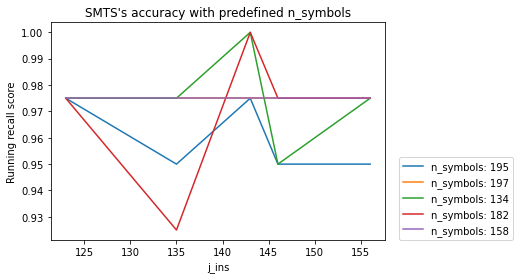

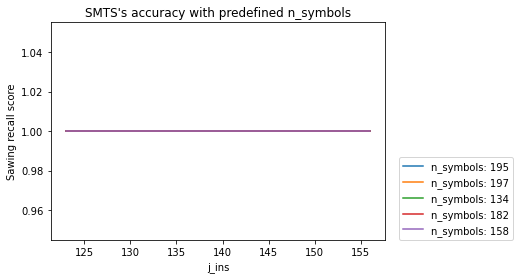

In [32]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


# <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

## <font color=#cd0000> Entrenamiento </font>

In [33]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=156,
    n_symbols=134,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id')\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[32  0  1  1]
 [ 2 34  1  0]
 [ 0  0 30  0]
 [ 0  0  0 37]]
              precision    recall  f1-score   support

    epilepsy       0.94      0.94      0.94        34
     running       1.00      0.92      0.96        37
      sawing       0.94      1.00      0.97        30
     walking       0.97      1.00      0.99        37

    accuracy                           0.96       138
   macro avg       0.96      0.97      0.96       138
weighted avg       0.96      0.96      0.96       138



# <font color=#cd0000> Conclusiones </font>
- Observamos unos resultados similares con respecto a aplicar únicamente una ``Codificación Simbólica`` y ``Tendencia``.